# Monte Carlo - Arrhenius Degredation 

Author: Tobin Ford | tobin.ford@nrel.gov

2023
***
short intro here
process and relevance (why shold the reader care, justification)

A monte carlo simulation can be used to predict results of an event with a certain amount of uncertainty. This will be introduced to our use case via mean and standard deviation for each modeling constant. Correlated multivariate monte carlo simulations expand on this by linking the behavior of multiple input variables together with correlation data, in our case we will use correlation coefficients but 

**Requirements:**
- `pvlib`, `numpy`, `matplotlib`

**Objectives**
1. Define necessary monte carlo simulation parameters : correlation coefficients, mean and standard standard deviation, number of trials, function to apply, requried function input
2. Define process for creating and utilizing modeling constant correlation data
3. Preform simple monte carlo simulation using arrhenius equation to calculate degredation and plot

In [ ]:

# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.1.1

In [16]:
import pvlib
import numpy as np
import pandas as pd
from pvdeg.montecarlo import Corr, generateCorrelatedSamples, vecArrhenius # idk why I have to import these individually 
import pvdeg
import matplotlib.pyplot as plt

## Correlated Monte Carlo Simulation (parameters)

For this simulation we will be using an arrhenius equation to calculate degredation rate given by $R_D = R_0 * I ^ X * e ^ {\frac{-Ea}{kT}}$, where R0 is prefactor degredation, I is irradiance, X is the irridiance relation, Ea is activation energy and T is degrees K

We will use R0, X and Ea to preform a 3 variable monte carlo simulation to calculate degredation.

### Required inputs
To run a monte carlo simulation with pvdeg.montecarlo the following inputs will be required
- function (currently only works with pvdeg.montecarlo.vecArrhenius() but will eventually work with most pvdeg calculation functions)
- other function arguments (ex: metadata, weather, cell temperature, solar position, etc.)
- mean and standard deviation (Required for all correlation constants)
- correlation constants (if not entered, default = 0)
- number of trials to run

### Defining Correlation Coefficients
pvdeg.montecarlo stores correlation coefficients in a Corr object. To represent a given correlation coefficient follow the given syntax below, replacing the values in the brackets with your correlation coefficients

    {my_correlation} = Corr('{name1}', '{name2}', {correlation coefficient})

note: ordering of name1 and name2 does not matter

After defining the all known correlations add them to a list which we will feed into our simulation later

In [ ]:
corr_Ea_X = Corr('Ea', 'X', 0.0269)
corr_Ea_LnR0 = Corr('Ea', 'LnR0', -0.9995)
corr_X_LnR0 = Corr('X', 'LnR0', -0.0400)

corr_coeff = [corr_Ea_X, corr_Ea_LnR0, corr_X_LnR0]

### Defining Mean and Standard Deviation
We will store the mean and correlation for each modeling constant, expressed when we defined the correlation cefficients. If a modeling constant is left out at this stage, the monte carlo simulation will throw errors.

In [ ]:
stats_dict = {
    'Ea' : {'mean' : 62.08, 'stdev' : 7.3858 },
    'LnR0' : {'mean' : 13.7223084 , 'stdev' : 2.47334772},
    'X' : {'mean' : 0.0341 , 'stdev' : 0.0992757 }
}

# and number of monte carlo trials to run
n = 20000

### Other Function Requirements (move this down????)
Based on the function chosen to run in the monte carlo simulation, various other data will be required. In this case we will need cell temperature and total plane of array irradiance.

The block below makes an NSRDB API call to get weather and meta data and then calculate cell temperature and global poa irradiance. (you will need to fill in the API_KEY and email values with your own information which can be obtained at https://developer.nrel.gov/signup/)

In [17]:
# MIAMI
latitude = 25.783388
longitude = -80.189029

API_KEY = 'replace' # REPLACE THESE VALUES with your information in string form
email ='replace' 

# reads NSRDB data 
weather_df, meta = pvlib.iotools.get_psm3(latitude, longitude, API_KEY, email, names='2019', map_variables=True)

sol_pos = pvdeg.spectral.solar_position(weather_df, meta)
poa_irradiance = pvdeg.spectral.poa_irradiance(weather_df, meta)
temp_mod = pvdeg.temperature.module(weather_df=weather_df, meta=meta, poa=poa_irradiance, conf='open_rack_glass_polymer')

# the function being used in the monte carlo simulation takes numpy arrays so we need to convert from pd.DataFrame to np.ndarray with .tonumpy()
poa_global = poa_irradiance['poa_global'].to_numpy()
cell_temperature = temp_mod.to_numpy()

c:\ProgramData\anaconda3\envs\monte-carlo\lib\site-packages\pvlib\iotools\psm3.py:183: pvlibDeprecationWarning: The ``get_psm3`` function will default to leap_day=True starting in pvlib 0.11.0. Specify leap_day=True to enable this behavior now, or specify leap_day=False to hide this warning.
  warnings.warn(


### Generating Monte Carlo Input Data
Next we will use the information collected above to generate correlated data from our modeling constant correlations, means and standard deviations.

In [ ]:
mc_inputs = generateCorrelatedSamples(corr_coeff, stats_dict, n)
print(mc_inputs)

#### Dummy Check
We can observe the mean and standard deviation of our newly correlated samples before using them for calculations to ensure that we have not incorrectly altered the data. The mean and standard deviation should be the similar (within a range) to your original input (the error comes from the standard distribution of generated random numbers)

This also applies to the correlation coefficients originally inputted, they should be witin the same range as those orginally supplied.

In [15]:
# mean and standard deviation match inputs 
for col in mc_inputs.columns:
    print(f"{col} : mean {mc_inputs[col].mean()}, stdev {mc_inputs[col].std()}")

print()

# come up with a better way of checking 
print('Ea_X', np.corrcoef(mc_inputs['Ea'], mc_inputs['X'])[0][1])
print('Ea_lnR0', np.corrcoef(mc_inputs['Ea'], mc_inputs['LnR0'])[0][1])
print('X_lnR0', np.corrcoef(mc_inputs['X'], mc_inputs['LnR0'])[0][1])

Ea : mean 61.993095965642084, stdev 7.349986892460632
LnR0 : mean 13.751124118529688, stdev 2.4605981912031796
X : mean 0.034297293522443, stdev 0.10033418386438851

Ea_X 0.023979057821387286
Ea_lnR0 -0.9994902118959185
X_lnR0 -0.037183555875157905


In [6]:
### pvdeg.montecarlo.simulate() ###
    # this needs to be moved into pvdeg.montecarlo
    # i didnt want to refactor yet

# this needs to be able to access the information it needs for generalized case
# ex) what happens when the column names change in the standoff function
# it should be able to grab the data via column names, how do we do this 

poa_global = poa_irradiance['poa_global'].to_numpy()
cell_temperature = temp_mod.to_numpy()

result = mc_inputs.apply(lambda row : vecArrhenius(poa_global, cell_temperature, row['Ea'], row['X'], row['LnR0']), axis=1)

print(result)

0        1.935053e-01
1        1.582038e-08
2        3.605063e-03
3        9.239252e-01
4        1.096336e-03
             ...     
19995    8.012804e-03
19996    1.629700e-01
19997    3.275455e-04
19998    2.967275e-08
19999    1.005561e-03
Length: 20000, dtype: float64
mean 53.44361811333543
stdev 6468.097741029581


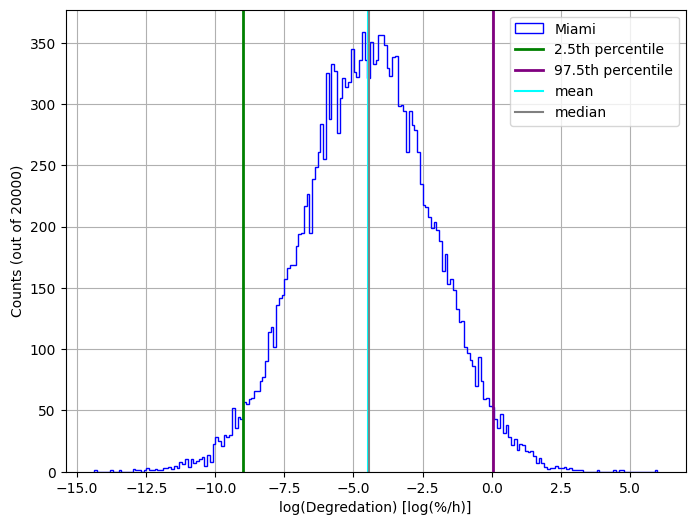

In [7]:
lnDeg = np.log10(result)
percentile_2p5 = np.percentile(lnDeg, 2.5)
percentile_97p5 = np.percentile(lnDeg, 97.5)
bin_edges = np.arange(lnDeg.min(), lnDeg.max() + 0.1, 0.1)

plt.figure(figsize=(8,6))
plt.hist(lnDeg, bins=bin_edges, edgecolor='blue', histtype='step', linewidth=1, label = 'Miami')

plt.axvline(percentile_2p5, color='green', label='2.5th percentile', linewidth=2.0)
plt.axvline(percentile_97p5, color='purple', label='97.5th percentile', linewidth=2.0)
plt.axvline(np.mean(lnDeg), color = 'cyan', label = 'mean' )
plt.axvline(np.median(lnDeg), color = 'gray', label = 'median')
plt.xlabel('log(Degredation) [log(%/h)]')
plt.ylabel(f'Counts (out of {n})')

plt.legend()
plt.grid(True)
plt.show()